# Impor Libraries

In [1]:
from modules.gnn import GNN
from modules.models import GraphSAGE, GCN
from modules.predictors import DotPredictor, MLPPredictor
import torch.nn.functional as F
from torch.optim import Adam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt

c:\Users\Vale\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Done saving data into cached files.
None
In epoch 0, loss: 1.1571556329727173
In epoch 10, loss: 0.7778046727180481
In epoch 20, loss: 0.546233057975769
In epoch 30, loss: 0.36428284645080566
In epoch 40, loss: 0.25624707341194153
In epoch 50, loss: 0.21222688257694244
In epoch 60, loss: 0.18201395869255066
In epoch 70, loss: 0.16697338223457336
In epoch 80, loss: 0.1559637188911438
In epoch 90, loss: 0.14827243983745575


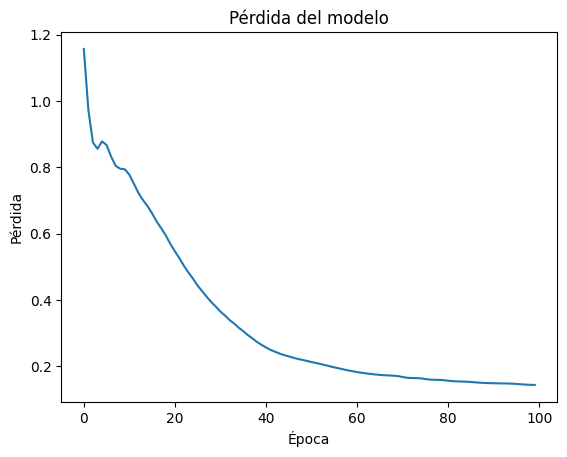

In [7]:

data_path = "datasets/DGL_Graph/MYCODEMultiDiGraph/"

gnn = GNN(debug = True)
gnn.load_dataset(data_path,force_reload= True) # No hay nodos con grado 0
gnn.split_dataset()


edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
# model = GCN(in_feats, h_feats, num_clases)
# pred = DotPredictor()

model = GraphSAGE(gnn.dgl_graph.ndata['feat'].shape[1], 16,8)
pred = MLPPredictor(8,3)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  # scores = torch.argmax(logits, dim=1)
  scores = logits.argmax(1)
  labels = gnn.dgl_graph.edata["Relationship"].to(torch.int64)
  loss = F.cross_entropy(logits[train_mask], labels[train_mask])

  # Almacenar el valor de pérdida
  loss_values.append(loss.item())

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))
    # scores_numpy = numpyscores.numpy()

# #     # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# # # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')



plt.plot(loss_values)
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()


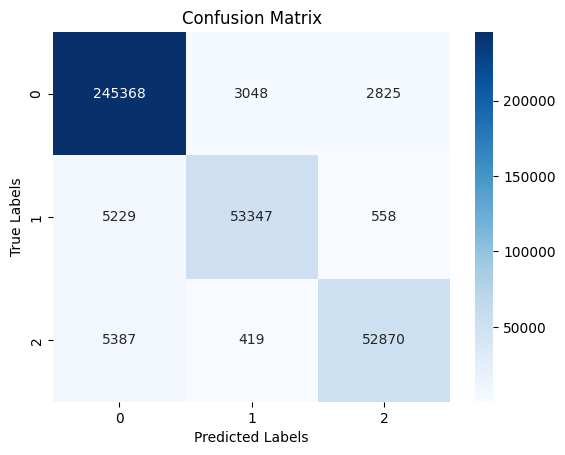

In [8]:
from utils import cal_acc_pres_f1
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
cal_acc_pres_f1(predicted_scores,true_labels, threshold=None)